In [55]:
# Import bibliotek
import pandas as pd
import math

from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

In [56]:
# Import danych w formacie CSV
data = pd.read_csv("datasets/dataset.txt", sep=";")

#Wyluskanie danych potrzebnych do analizy i przygotowanie zbioru do pracy
data = data[["ecordinTime [ms]", "Stimulus", "Participant", "Category Right", "Index Right", "Point of Regard Right X [px]", "Point of Regard Right Y [px]"]]

data = data[data["Category Right"] == "Fixation"]
data = data[["ecordinTime [ms]", "Stimulus", "Participant", "Index Right", "Point of Regard Right X [px]", "Point of Regard Right Y [px]"]]
data = data[data["Stimulus"].isin(["Grid Page 1", "Carousel Page 1", "List Page 1"])]
data = data.rename(columns={"Index Right": "Fixation Index"}).reset_index()
data = data.drop("index", axis=1)
data["Fixation Index"] = data["Fixation Index"].astype(int)
data["ecordinTime [ms]"] = data["ecordinTime [ms]"].astype(float)
data["Point of Regard Right X [px]"] = data["Point of Regard Right X [px]"].astype(float)
data["Point of Regard Right Y [px]"] = data["Point of Regard Right Y [px]"].astype(float)
data['Stimulus'] = data['Stimulus'].str.replace(' Page 1', '')
data = data[data["Participant"] != "test"]
data = data[(data["Point of Regard Right X [px]"] > 0 ) & (data["Point of Regard Right Y [px]"] > 0)]
data

,ecordinTime [ms],Stimulus,Participant,Fixation Index,Point of Regard Right X [px],Point of Regard Right Y [px]
0,492478.9,List,SK,1,816.5,422.1
1,492480.9,List,SK,1,818.3,420.9
2,492482.9,List,SK,1,821.0,420.7
3,492484.9,List,SK,1,820.1,419.8
4,492486.9,List,SK,1,820.6,418.7
...,...,...,...,...,...,...
73491,2316349.5,Carousel,KU,8,1180.9,545.0
73492,2316351.5,Carousel,KU,8,1182.5,545.0
73493,2316353.5,Carousel,KU,8,1181.9,545.9
73494,2316355.5,Carousel,KU,8,1179.6,545.9


In [57]:
# Pobranie nazw uczestnikow badania
participants_names = data["Participant"].unique().tolist()

# Pobranie nazw stimulusow
stimulus_names = data["Stimulus"].unique().tolist()
stats = []

# Pobranie ilosci fiksacji dla kazdego uzytkownika
for name in participants_names:
    t = [name]

    for stimulus in stimulus_names:
        f_num = len(data[(data["Stimulus"] == stimulus) & (data["Participant"] == name)]["Fixation Index"].unique())
        t.append((stimulus, f_num))

    stats.append(t)

# Wyswietlenie zbiorczych statystyk uczestnikow     
display(stats)

[['SK', ('List', 19), ('Carousel', 19), ('Grid', 16)],
 ['AM', ('List', 7), ('Carousel', 6), ('Grid', 11)],
 ['MK', ('List', 21), ('Carousel', 22), ('Grid', 19)],
 ['DM', ('List', 20), ('Carousel', 24), ('Grid', 17)],
 ['PL', ('List', 22), ('Carousel', 23), ('Grid', 22)],
 ['PK', ('List', 5), ('Carousel', 6), ('Grid', 8)],
 ['BM', ('List', 2), ('Carousel', 2), ('Grid', 18)],
 ['FK', ('List', 21), ('Carousel', 25), ('Grid', 26)],
 ['AT', ('List', 20), ('Carousel', 24), ('Grid', 27)],
 ['SM', ('List', 17), ('Carousel', 21), ('Grid', 20)],
 ['KU', ('List', 10), ('Carousel', 8), ('Grid', 10)]]

In [58]:
def calculate(x, y, stim):

    # Rozmiary strony oraz ekranu
    x_res = 1680
    y_res = 1050
    page_width = 1920
    page_height = 0

    if stim == "Carousel":
        page_height = 2191

    if stim == "Grid" or stim == "List":
        page_height = 2912

    # Przeksztalcenie liniowe
    prop = (page_height / y_res)
    physical_width = x_res / prop
    offset = 0.5*(x_res - physical_width)
    x = ((x-offset)/physical_width) * page_width
    y = (y / y_res) * page_height

    return [x, y]

# Metoda do sprawdzania, czy pod przekazanymi koordynatami znajduje sie jakis produkt
def check_coords(x, y, stim):

    x, y = calculate(x, y, stim)

    # Sprawdzanie czy pod wspolrzednymi kryja sie produkty    
    if stim == "Grid":

        coords = [
            (600, 950, 800, 1300),
            (1050, 1400, 800, 1300),
            (1500, 1850, 800, 1300),
            (600, 950, 1380, 1880),
            (1050, 1400, 1380, 1880),
            (1500, 1850, 1380, 1880),
            (600, 950, 1960, 2460),
            (1050, 1400, 1960, 2460),
            (1500, 1850, 1960, 2460),
        ]

        i = 1
        for c in coords:
            if (c[0] <= x <= c[1]) and (c[2] <= y <= c[3]): return [x, y, i]
            i +=1

        return [x, y, -1]


    if stim == "List":

        coords = [
            (600, 1800, 800, 1100),
            (600, 1800, 1120, 1420),
            (600, 1800, 1440, 1740),
            (600, 1800, 1760, 2060),
            (600, 1800, 2080, 2380),
        ]

        i = 1
        for c in coords:
            if (c[0] <= x <= c[1]) and (c[2] <= y <= c[3]): return [x, y, i]
            i += 1

        return [x, y, -1]

    if stim == "Carousel":

        coords = [
            (20, 370, 1086, 1584),
            (390, 740, 1086, 1584),
            (760, 1210, 1086, 1584),
            (1130, 1480, 1086, 1584),
            (1500, 1850, 1086, 1584),
        ]

        i = 1
        for c in coords:
            if (c[0] <= x <= c[1]) and (c[2] <= y <= c[3]): return [x, y, i]
            i += 1

        return [x, y, -1]
        

In [59]:
products = pd.DataFrame(columns=["Start Time", "Participant", "Stimulus", "X", "Y"])

# Stworzenie ramki danych z obserwacji uzytkownikow
for person in stats:
    for stim in person[1:]:
        for fix in range(1, stim[1] + 1):
            data_temp = data[(data["Participant"]==person[0]) & (data["Stimulus"]==stim[0]) & (data["Fixation Index"]==fix)]
            x_mean = data_temp["Point of Regard Right X [px]"].median()
            y_mean = data_temp["Point of Regard Right Y [px]"].median()
            time_start = data_temp["ecordinTime [ms]"].min() / 1000
            x, y, p_id = check_coords(x_mean, y_mean, stim[0])

            if not math.isnan(x) and not math.isnan(y): products.loc[len(products.index)] =  [time_start, person[0], stim[0], round(x), round(y)]

products

,Start Time,Participant,Stimulus,X,Y
0,492.4789,SK,List,914,1171
1,492.8330,SK,List,765,1166
2,493.8235,SK,List,604,952
3,494.2698,SK,List,1341,960
4,494.5057,SK,List,632,969
...,...,...,...,...,...
531,2301.9855,KU,Grid,1145,1417
532,2303.0519,KU,Grid,1800,1180
533,2303.3340,KU,Grid,1382,1780
534,2303.8962,KU,Grid,1225,1691


In [105]:
def draw_plot(part, stim):
    data_to_plot = products[(products["Stimulus"] == stim) & (products["Participant"] == part)]
    
    page_height = 0

    if stim == "Carousel":
        page_height = 2191

    if stim == "Grid" or stim == "List":
        page_height = 2912

    image = Image.open("assets/" + stim + ".png")
    image_array = np.array(image)

    height, width, channels = image_array.shape
    x, y = np.meshgrid(np.arange(width), np.arange(height))
    colors = image_array.reshape((width * height, channels))

    fig = plt.figure(figsize=(9, 9))
    ax = fig.add_subplot(111, projection='3d', computed_zorder=False)

    z = np.full(shape=(page_height, 1920), fill_value=0.999*data_to_plot["Start Time"].min(), dtype=int)
    
    ax.scatter(x.flatten(), y.flatten(), z.flatten(), c=colors / 255.0, s=1, zorder=-1)

    ax.scatter(data_to_plot["X"], data_to_plot["Y"], data_to_plot["Start Time"],
               s=100, c="steelblue", zorder=1.1, facecolors='steelblue', alpha=1)

    ax.plot(data_to_plot["X"], data_to_plot["Y"], data_to_plot["Start Time"], color='black', linewidth=1, zorder=1)

    ax.set_xlim([0, 1920])
    ax.set_ylim([0, page_height])
    
    ax.set_box_aspect([1920, page_height, 2500])

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    ax.set_zticks([])
    ax.invert_yaxis()

    # ax.view_init(elev=0, azim=0) # You can uncomment this line to change camera position
    
    plt.show()


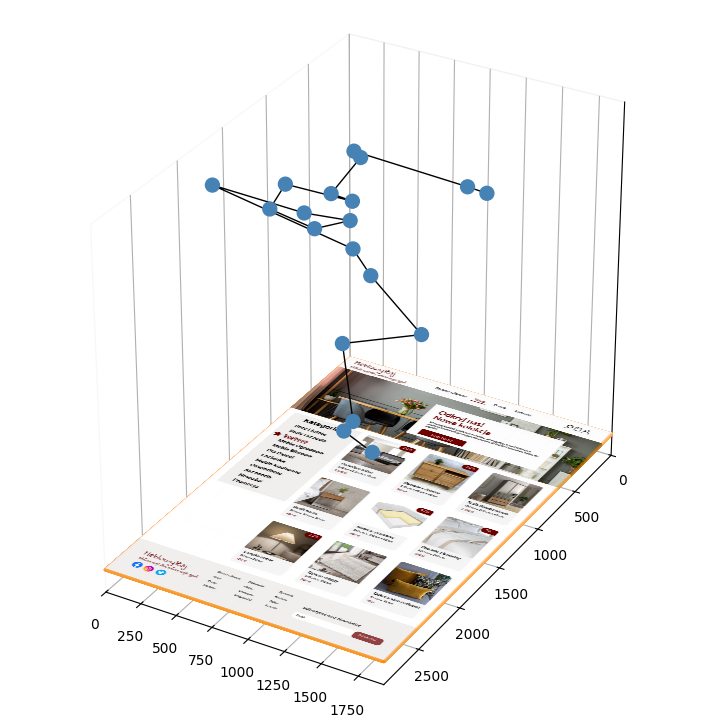

In [106]:
draw_plot("MK", "Grid")